# L2 Noisepropagation and detection limit analysis for TANGO CO2

In [1]:
# Setting up the TEDS environment
import sys
import os
sys.path.append("/nfs/Tango/users/tobiasb/teds/")
sys.path.append("/nfs/Tango/users/tobiasb/jupyter/TEDS_l4/")
os.chdir("/nfs/Tango/users/tobiasb/teds/")

In [2]:
#Importing packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from teds.lib.libNumTools import convolution_2d, getconvolutionparams
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import ttest_ind
from joblib import Parallel, delayed

## Reading the MicroHH simulation

In [3]:
# define paths
#data_path="/stage/tobiasb/manu/Detectionlimit/data/microhh_co2.h5"
#data_path="/nfs/Tango/users/tobiasb/manu_detection/gitversion/DetectionLimit/data/Microhh_CO2.h5"
#data_path="/nfs/Tango/users/tobiasb/manu_detection/read_scripts/new.h5"
#data_path="/nfs/Tango/users/tobiasb/simtest/readoutput/new_5ms.h5"
#data_path="/nfs/Tango/users/tobiasb/simtest/readoutput/new_3ms.h5"
data_path="/nfs/Tango/users/tobiasb/simtest/readoutput/microhh_3ms_25plumes.h5"

In [4]:
# Load microHH simulation data
sim_data = xr.open_dataset(data_path)
grid_data = xr.open_dataset(data_path, group="grid")

# Extract available time steps of the simulations
# we ignore the first steps to let the plume built up
times=[s for s in dir(sim_data) if s.endswith("00")][5:]
print("Simulation time steps:", times)

# Extract source location and grid vectors
source_location = np.array(sim_data["source"].values, dtype=int)
x = grid_data["x"].values
y = grid_data["y"].values

# Sampling of the microHH simulation
dx = x[1] - x[0]
dy = y[1] - y[0]
print("Spatial resolution:", dx, dy)

# Create meshgrid for original and resampled coordinates
x_grid, y_grid = np.meshgrid(x, y)
resampled_x = np.arange(x[0], x[-1], 300)
resampled_y = np.arange(y[0], y[-1], 300)
resampled_x_grid, resampled_y_grid = np.meshgrid(resampled_x, resampled_y)

# Compute distances to the source location
distances = np.sqrt((resampled_x_grid - source_location[0])**2 + (resampled_y_grid - source_location[1])**2)

# Find the index of the nearest point
nearest_point_idx = np.unravel_index(np.argmin(distances), distances.shape)
nearest_source=(resampled_y[nearest_point_idx[1]], resampled_x[nearest_point_idx[0]])
print("Index of nearest point:", nearest_point_idx)

# Get emission strength
emission_strength=sim_data[times[0]].strength


Simulation time steps: ['15600', '16800', '18000', '19200', '20400', '21600', '22800', '2400', '24000', '25200', '26400', '27600', '28800', '3600', '4800', '6000', '7200', '8400', '9600']
Spatial resolution: 16.0 16.0
Index of nearest point: (27, 3)


## microHH simultation on TANGO resolution (Convolution/Resampling)

In [5]:
# Downsampling the microHH simulation to the instrument resolution
config = {
    'kernel_parameter': {},
    'type': '2D Gaussian',
    'fwhm_x': 300,
    'fwhm_y': 300,
    'size_factor': 2
}
conv_config = getconvolutionparams(config, dx, dy)

# Initialize plume array
plume_array = np.zeros((len(resampled_y), len(resampled_x), len(times)))

# Perform convolution and regridding for each time step
for idx, time in enumerate(times):
    XCO2 = np.array(sim_data[time].values)/emission_strength
    
    # Apply convolution with the instrument response function
    XCO2_convolved = convolution_2d(XCO2, conv_config)
    
    # Regrid data onto the coarse resolution
    interpolator = RegularGridInterpolator((y, x), XCO2_convolved, bounds_error=False, fill_value=0.0)
    plume_array[:, :, idx] = interpolator((resampled_y_grid, resampled_x_grid))


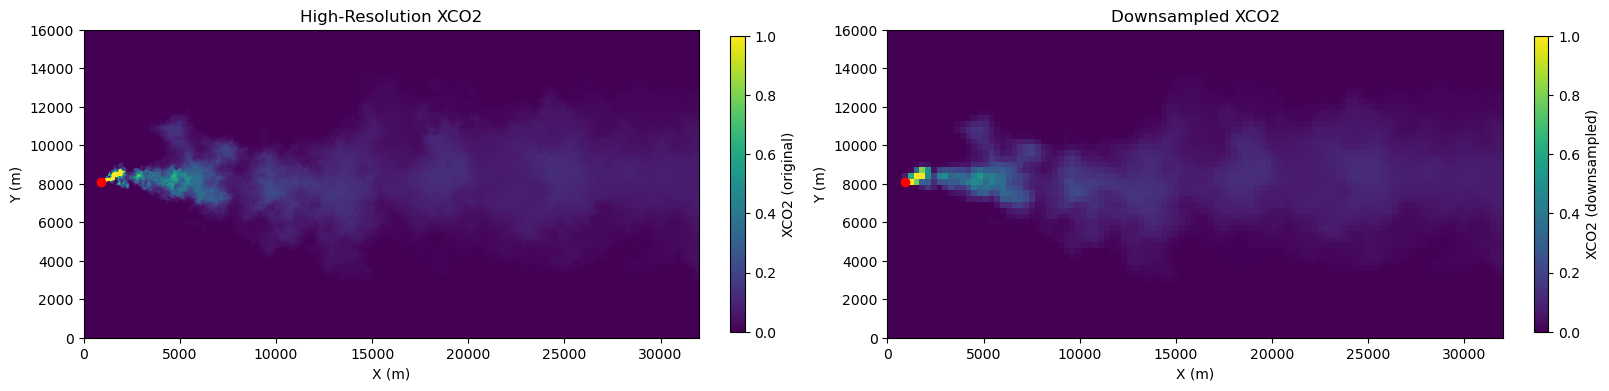

In [6]:
# Plot original high-resolution data and downsampled data side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# High-resolution XCO2 plot
axes[0].pcolormesh(x_grid, y_grid, sim_data[times[0]].values, vmin=0, vmax=10, shading='auto')
axes[0].scatter(nearest_source[0], nearest_source[1], color="red")
axes[0].set_xlim(0, 32000)
axes[0].set_ylim(0, 16000)
axes[0].set_title('High-Resolution XCO2')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_aspect("equal",adjustable="box")
cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[0], shrink=0.5)
cbar1.set_label('XCO2 (original)')

# Downsampled XCO2 plot
axes[1].pcolormesh(resampled_x_grid, resampled_y_grid, plume_array[:, :, 0] * emission_strength, vmin=0, vmax=10, shading='auto')
axes[1].scatter(nearest_source[0], nearest_source[1], color="red")
axes[1].set_xlim(0, 32000)
axes[1].set_ylim(0, 16000)
axes[1].set_title('Downsampled XCO2')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_aspect("equal",adjustable="box")
cbar2 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1], shrink=0.5)
cbar2.set_label('XCO2 (downsampled)')

plt.show()


## Creating a L2 measurement noise

In [7]:

# Define noise characteristics for the instrument
noise_std=412*0.005
noise_seed = 100  # Seed for noise generation
num_noise_samples = 1000  # Number of noise samples

# Set random seed for reproducibility
np.random.seed(noise_seed)

# Generate noise array with normal distribution
noise = np.random.normal(0.0, noise_std, resampled_x_grid.shape + (num_noise_samples,))


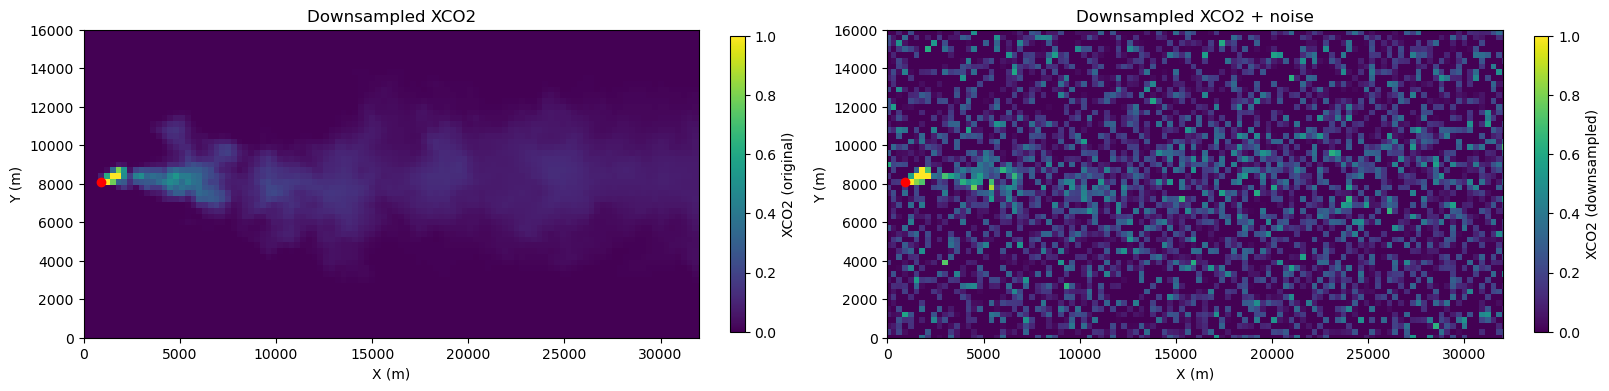

In [8]:
# Plot downsampled and the one with noise  side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# High-resolution XCO2 plot
axes[0].pcolormesh(resampled_x_grid, resampled_y_grid, plume_array[:, :, 0] * emission_strength, vmin=0, vmax=10, shading='auto')
axes[0].scatter(nearest_source[0], nearest_source[1], color="red")
axes[0].set_xlim(0, 32000)
axes[0].set_ylim(0, 16000)
axes[0].set_title('Downsampled XCO2')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_aspect("equal",adjustable="box")
cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[0], shrink=0.5)
cbar1.set_label('XCO2 (original)')

# Downsampled XCO2 plot
axes[1].pcolormesh(resampled_x_grid, resampled_y_grid, plume_array[:, :, 0] * emission_strength +noise[:,:,0], vmin=0, vmax=10, shading='auto')
axes[1].scatter(nearest_source[0], nearest_source[1], color="red")
axes[1].set_xlim(0, 32000)
axes[1].set_ylim(0, 16000)
axes[1].set_title('Downsampled XCO2 + noise')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_aspect("equal",adjustable="box")
cbar2 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1], shrink=0.5)
cbar2.set_label('XCO2 (downsampled)')

plt.show()

In [9]:
# Define emission levels and initialize probability array
# Emission levels range from 1 to 3 with a step of 0.1
emission_levels = np.arange(1, 3, 0.1)
detection_probabilities = np.zeros(len(emission_levels))
l4_error = np.zeros(len(emission_levels))

## Propagating L2 measurement noise to the L4 emissions error

In [10]:
# calculate for each plume the l2 noise propagation on l4
sqrt_sx = np.zeros(len(times))

for sim_idx in range(len(times)):

    plume = plume_array[:, :, sim_idx]
    
    # Define a retrieval mask where the plume is greater than zero
    retrieval_mask = plume > 0
    Kern = plume[retrieval_mask]
    ystd = noise_std * np.ones(Kern.size)  # Standard deviation for the noise
    Sy_inv = np.diag(1. / np.square(ystd))  # Inverse of noise covariance matrix
    Sy = np.diag(ystd ** 2)  # Noise covariance matrix
    Gain = 1. / (Kern.T @ Sy_inv @ Kern) * Kern.T @ Sy_inv  # Gain calculation
    Sx = Gain @ Sy @ Gain.T  # Posterior covariance matrix
    sqrt_sx[sim_idx]=np.sqrt(Sx)


for i in range(len(emission_levels)):
    l4_error[i]=np.mean(sqrt_sx/emission_levels[i]*100)


## Estimating the detection limit for different emissions strength

In [11]:

# Function to process a single emission level
# This function calculates detection probabilities for a given emission level
def process_emission_level(emission, plume_array, noise, noise_std, distances, num_noise_samples, times, mask_method):
    detection_count = 0
    plume_detected = np.zeros(num_noise_samples * len(times))

    for sim_idx in range(len(times)):
        # Scale the emission for the current simulation
        plume = plume_array[:, :, sim_idx]
        scaled_plume = plume * emission

        # Define detection mask
        # Detection is based on plume values being above noise and within 10 km
        if mask_method == "distance":
            detection_mask = (distances < 10000) & (scaled_plume > 0)
        else:
            detection_mask = scaled_plume> noise_std

        # Iterate over noise realizations
        for noise_idx in range(num_noise_samples):
            noisy_measurement = scaled_plume + noise[:, :, noise_idx]

            # Extract values based on detection mask
            detected_values = noisy_measurement[detection_mask]
            undetected_values = noisy_measurement[~detection_mask]

            # Perform t-test to compare detected and undetected groups
            t_stat, p_value = ttest_ind(detected_values, undetected_values, equal_var=False)

            # Record detection if t-test criteria are met
            if t_stat > 0.0 and p_value < 0.01:
                plume_detected[detection_count] = 1

            detection_count += 1

    # Calculate detection probability and average L4 error
    detection_probability = np.mean(plume_detected)

    return detection_probability

# Parallelize the loop over emission levels
# Use joblib for parallel processing to improve performance

mask_method="distance"

results_distance = Parallel(n_jobs=-1)(
    delayed(process_emission_level)(emission, plume_array, noise, noise_std, distances, num_noise_samples, times, mask_method)
    for emission in emission_levels
)

mask_method="noise"

results_noise = Parallel(n_jobs=-1)(
    delayed(process_emission_level)(emission, plume_array, noise, noise_std, distances, num_noise_samples, times, mask_method)
    for emission in emission_levels
)

# Unpack results into separate arrays
# Detection probabilities and L4 error are stored for each emission level
detection_probabilities_distance = np.array(results_distance)
detection_probabilities_noise = np.array(results_noise)

/deos/tobiasb/anaconda3/envs/teds/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/deos/tobiasb/anaconda3/envs/teds/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/deos/tobiasb/anaconda3/envs/teds/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/deos/tobiasb/anaconda3/envs/teds/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/deos/tobiasb/anaconda3/envs/teds/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero

## Visualization of results

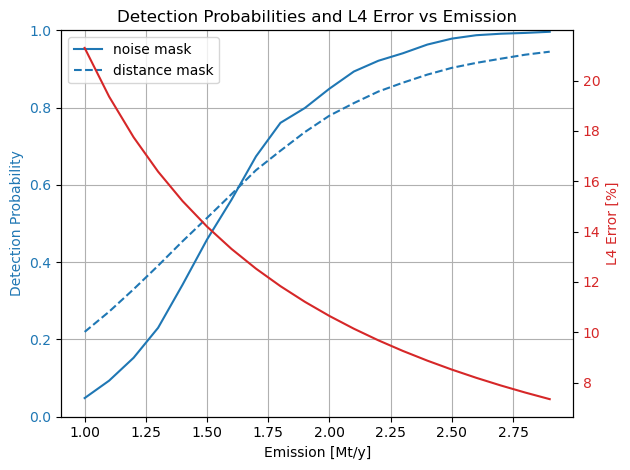

Emission [Mt/y]: [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9]
Detection Probability: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L4 Error [%]: [21.2972904  19.36117309 17.747742   16.38253108 15.21235029 14.1981936
 13.3108065  12.52781788 11.831828   11.20910021 10.6486452  10.14156686
  9.68058655  9.25969148  8.873871    8.51891616  8.19126554  7.88788533
  7.60617514  7.34389324]


In [12]:
# Plot detection probabilities and L4 error on the same plot with dual y-axes
fig, ax1 = plt.subplots()

# Plot detection probabilities on the left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Emission [Mt/y]')
ax1.set_ylabel('Detection Probability', color=color1)
ax1.plot(emission_levels, detection_probabilities_noise, color=color1, label='noise mask')
ax1.plot(emission_levels, detection_probabilities_distance, color=color1, label='distance mask',linestyle="--")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend()
ax1.set_ylim(0.0, 1)
ax1.grid(True)

# Create a second y-axis for L4 error
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:red'
ax2.set_ylabel('L4 Error [%]', color=color2)
ax2.plot(emission_levels, l4_error, color=color2, linestyle='-', label='L4 Error [%]')
ax2.tick_params(axis='y', labelcolor=color2)

# Add a title and show the plot
plt.title('Detection Probabilities and L4 Error vs Emission')
fig.tight_layout()
plt.show()

# Debugging: Print the data
print("Emission [Mt/y]:", emission_levels)
print("Detection Probability:", detection_probabilities)
print("L4 Error [%]:", l4_error)

## Example: detection limit calculation for one plume only

In [13]:
# Debugging the Plume Detection Script

# Simulation parameters
sim_idx = -1  # Index for the simulation to debug
noise_idx = 0  # Index for the noise realization
emission = 2.5  # Emission scaling factor
mask_method="distance"

# Extract the plume data for the selected simulation index
plume = plume_array[:, :, sim_idx]
scaled_plume = plume * emission  # Scale the plume by the emission factor

# Add noise to the scaled plume
noisy_measurement = scaled_plume + noise[:, :, noise_idx]

# Detection mask: Identify areas where the scaled plume exceeds noise standard deviation
if mask_method=="distance":
    detection_mask = (distances < 10000) & (scaled_plume > 0)
else:
    detection_mask = scaled_plume > noise_std

# Extract detected and undetected values based on the detection mask
detected_values = noisy_measurement[detection_mask]
undetected_values = noisy_measurement[~detection_mask]

# Perform a two-sample t-test to compare detected and undetected groups
t_stat, p_value = ttest_ind(detected_values, undetected_values, equal_var=False)

# Print t-test results for statistical comparison
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4e}")


T-statistic: 3.4987, P-value: 4.9937e-04


### Show the noisy measurement and the plume mask used

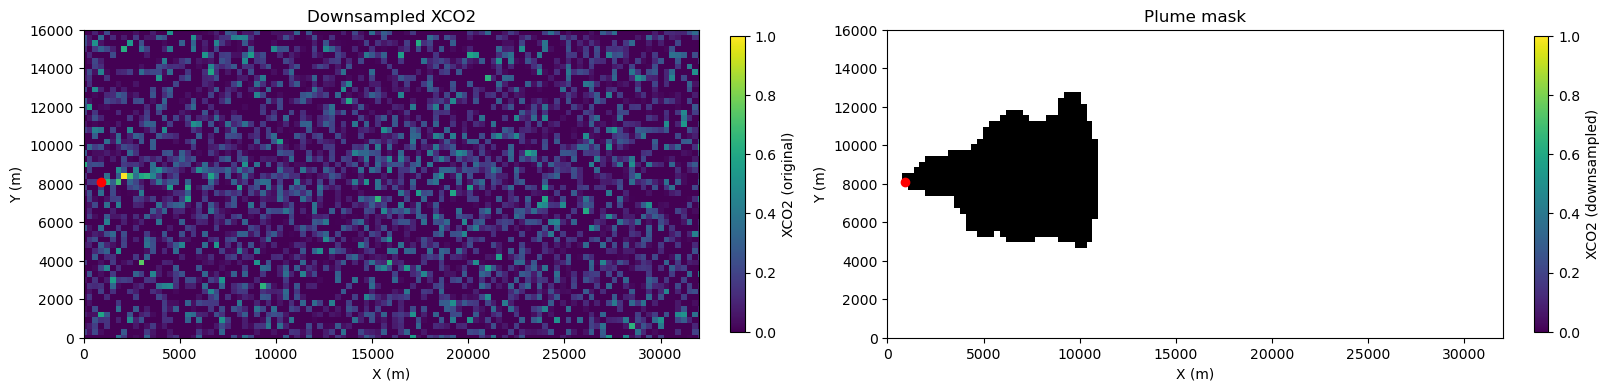

In [14]:
# Plot downsampled and the one with noise  side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# High-resolution XCO2 plot
axes[0].pcolormesh(resampled_x_grid, resampled_y_grid, noisy_measurement, vmin=0, vmax=10, shading='auto')
axes[0].scatter(nearest_source[0], nearest_source[1], color="red")
axes[0].set_xlim(0, 32000)
axes[0].set_ylim(0, 16000)
axes[0].set_title('Downsampled XCO2')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_aspect("equal",adjustable="box")
cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[0], shrink=0.5)
cbar1.set_label('XCO2 (original)')

# Downsampled XCO2 plot
axes[1].pcolormesh(resampled_x_grid, resampled_y_grid, detection_mask, vmin=0, vmax=1, shading='auto',cmap="binary")
axes[1].scatter(nearest_source[0], nearest_source[1], color="red")
axes[1].set_xlim(0, 32000)
axes[1].set_ylim(0, 16000)
axes[1].set_title('Plume mask')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_aspect("equal",adjustable="box")
cbar2 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1], shrink=0.5)
cbar2.set_label('XCO2 (downsampled)')

plt.show()

### Show the difference of the L2 data distribution within/outside the plume 

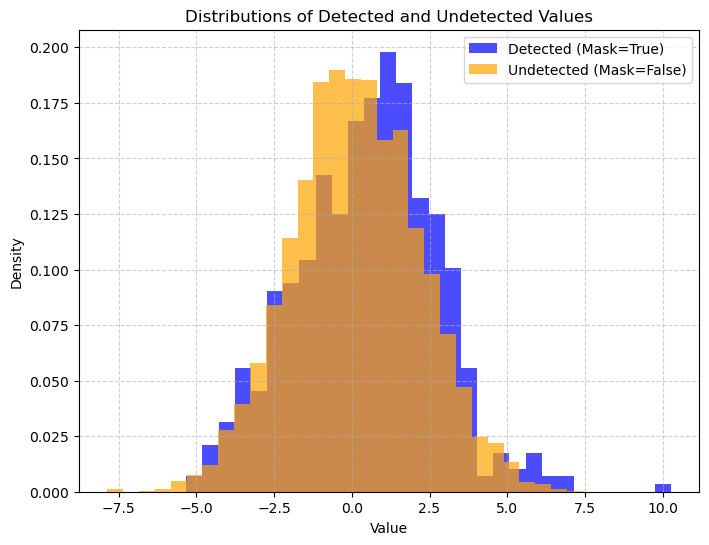

In [15]:

# Plot histograms of detected and undetected values
plt.figure(figsize=(8, 6))
plt.hist(
    detected_values,
    bins=30,
    alpha=0.7,
    label="Detected (Mask=True)",
    density=True,
    color="blue",
)
plt.hist(
    undetected_values,
    bins=30,
    alpha=0.7,
    label="Undetected (Mask=False)",
    density=True,
    color="orange",
)
plt.legend()
plt.title("Distributions of Detected and Undetected Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
